# Проект Создание/разработка скрипта для анализа переписок в чатах.

Цели проекта:
* Повысить вовлеченность в жизнь сообщества
* Снизить операционную нагрузку на комьюнити менеджеров на 30%
а также поднять конверсию вступления в выпускные комьюнити на +5%

Какие основные функции должны быть реализованы?
* инструмент для аналитики переписки
* суммаризация полученной информации
* написание итогов обсуждений в 2х форматах:
  1. дайджест для участников (с настройкой периодичности: обсуждения за день/за неделю/за месяц) со ссылками на сообщения участников
  2. сбор информации для комьюнити-менеджеров: рейтинг тем, которые обсуждали в сообществе с частотой обсуждений

Какую структуру и какие разделы необходимо реализовать в проекте?  
Результатом проекта является скрипт, который выдает результаты, с разбивкой на следующие этапы :
* инструмент для аналитики переписки
* суммаризация полученной информации
* написание итогов обсуждений в 2х формата:
дайджест для участников (с настройкой периодичности: обсуждения за день/за неделю/за месяц) со ссылками на сообщения участников и сбор информации для комьюнити-менеджеров: рейтинг тем, которые обсуждали в сообществе с частотой обсуждений


Аналитика сообщений выполняется скриптом, результаты которого сохраняются в виде CSV-файла с четко определёнными столбцами. Скрипт должен собирать данные о количестве сообщений в чате за заданные временные промежутки с возможностью гибкой настройки периодичности запуска: обычно один раз в месяц, иногда раз в неделю и, в редких случаях, ежедневно.


# Парсинг

In [2]:
import json
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, HourLocator, MinuteLocator

import networkx as nx
import ollama
import openpyxl

import time
from tqdm import tqdm  # для прогресс-бара

KeyboardInterrupt: 

In [7]:
# # робота с Google Диском
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# # Путь к json ввожу вручную
# %cd /content/drive/My Drive/Colab Notebooks/Projects/Master_Ya
# path_json = os.getcwd() + '/down/маркетинг/result.json'
# path_json

In [3]:
path_json = os.getcwd() + '\\result.json'
path_json

'c:\\Users\\Виталик\\Desktop\\Pro\\Pet\\Master_yandex\\result.json'

In [4]:
# Загружаем JSON-файл
with open(path_json, 'r', encoding='utf-8') as file:
    chat_data = json.load(file)

In [5]:
# Извлекаем сообщения, а также название чата(в JSON-файл один чат) и chat_id
messages = chat_data.get('messages', [])
chat_name = chat_data.get('name')
chat_id = chat_data.get('id')

In [6]:
# Парсим текстовые сообщения
parsed_messages = []
for message in messages:
    # отсекаем служебные сообщения  type: service
    if message.get('type') == 'message':
        text = message['text']
        parsed_messages.append({
            'message_id': message['id'],
            'date': message['date'],
            'chat_name': chat_name,
            'chat_id': chat_id,
            'sender_id': message.get('from_id'),
            'from': message.get('from', 'Unknown'),
            'text': text
        })

In [7]:
# Создаем датафрейм
df = pd.DataFrame(parsed_messages)

In [8]:
df

,message_id,date,chat_name,chat_id,sender_id,from,text
0,42471,2025-02-01T07:35:54,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы..."
1,42472,2025-02-01T07:40:03,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"А вот регионы, в которых живут ITшники с интер..."
2,42473,2025-02-01T07:48:53,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"Если смотреть по интересам, то кажется, что ау..."
3,42474,2025-02-01T07:50:31,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,А путь пользователя почему-то выглядит так. Ко...
4,42475,2025-02-01T08:12:42,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,Опять он
...,...,...,...,...,...,...,...
3675,46400,2025-02-27T20:11:04,💬 Marketing Practicum Chat,1782474569,user1829741608,Алексей Ермолов,"Напишу им, спасибо."
3676,46401,2025-02-27T20:23:08,💬 Marketing Practicum Chat,1782474569,user1912824918,S,"Старые профили не удаляются, номер на который ..."
3677,46402,2025-02-27T20:24:44,💬 Marketing Practicum Chat,1782474569,user1912824918,S,Пишите оператору (позовите пожалуйста оператор...
3678,46403,2025-02-27T20:29:44,💬 Marketing Practicum Chat,1782474569,user1829741608,Алексей Ермолов,Отлично! Благодарю.


In [10]:
print(df['text'].head())

0    [Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...
1    А вот регионы, в которых живут ITшники с интер...
2    Если смотреть по интересам, то кажется, что ау...
3    А путь пользователя почему-то выглядит так. Ко...
4                                             Опять он
Name: text, dtype: object


In [15]:
df.head(10).style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})

,message_id,date,chat_name,chat_id,sender_id,from,text
0,42471,2025-02-01T07:35:54,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"['Доброе утро, люди! Это ОК, в РСЯ алгоритмы выбрали только 1 площадку для объявлений? Объект рекламы - ""консультации для IT компаний"". Почему решили все объявления показывать на ', {'type': 'link', 'text': 'game.yandex.ru'}, ', Я в корректировках рекламной кампании поставил ограничения аудитории по возрасту, от 24 лет... Получается, что все айтишники старше 24 лет обитают в играх Яндекс?']"
1,42472,2025-02-01T07:40:03,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"А вот регионы, в которых живут ITшники с интересом к нашему предложению. Эти люди провели на сайте больше 1 минуты"
2,42473,2025-02-01T07:48:53,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"Если смотреть по интересам, то кажется, что аудитория релевантная"
3,42474,2025-02-01T07:50:31,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,А путь пользователя почему-то выглядит так. Конверсий в заявку нету😭
4,42475,2025-02-01T08:12:42,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,Опять он
5,42476,2025-02-01T08:12:42,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,
6,42477,2025-02-01T08:15:13,💬 Marketing Practicum Chat,1782474569,user87502689,Андрей Дамаскин,Потому и выбрал
7,42478,2025-02-01T08:15:32,💬 Marketing Practicum Chat,1782474569,user87502689,Андрей Дамаскин,"Ну если это вся статистика, то пока алгоритм еще ничего не выбрал"
8,42479,2025-02-01T08:16:44,💬 Marketing Practicum Chat,1782474569,user87502689,Андрей Дамаскин,"Чтобы 34 визита из РСЯ превратились в заявку нужна конверсия на уровне 3%, для необученной РК не реально же"
9,42480,2025-02-01T08:17:32,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,Батя привет


Вывод: В резельтате парсинга json-файла про маркетинг. Получил датафрейм с признаками
* message_id - индекс сообщения
* date - время
* chat_name - название чата
* chat_id	- индекс чата
* sender_id	- индекс пользователя
* from - ФИ пользователя
* text - текст сообщения
* 3680 rows × 7 columns

# Метод №1. Кластеризация по reply и по соседним сообщениям с временным threshold`ом

Суть подхода:  
Необходимо выделить в кластеры сообщения, связанные между собой с помощью механики reply. Также добавить в эти кластеры соседние сообщения с маленьким временным порогом. Я использовал th_minute=0.5.  


План реализации:
* добавить в датафрейм информацию об reply
* собрать в список пары индексов сообщений связанных reply
* добавить в список пары индексов соседних сообщений (30 секунд)
* разбиваем сообщения на кластеры с помощью полученных связей через networkx и Graf
* топ 10 диалогов по количеству сообщений
* анализ результата

In [16]:
# Добавил в парсинг reply_to_message_id
parsed_messages = []
for message in messages:
    if message.get('type') == 'message':
        text = message['text']
        parsed_messages.append({
            'message_id': message['id'],
            'date': message['date'],
            'chat_name': chat_name,
            'chat_id': chat_id,
            'sender_id': message.get('from_id'),
            'from': message.get('from', 'Unknown'),
            'reply_to_message_id': message.get('reply_to_message_id'),
            'text': text
        })

In [17]:
df = pd.DataFrame(parsed_messages)

In [18]:
# Собирю пары Id сообщений по reply_to_message_id
x = []
for i in range(len(df)-1, -1, -1):
  if not pd.isna(df.loc[i, 'reply_to_message_id']):
    x.append([df.loc[i, 'message_id'], df.loc[i, 'reply_to_message_id']])

In [19]:
df['date'] = pd.to_datetime(df['date'])

In [20]:
# Добавляю пары соседних сообщений с порогом в полминуты
# Порог выбрал в ручную, при таком порого 1500 событий
th_minute=0.5
for i in range(len(df)-1):
  if df.loc[i+1, 'date']-df.loc[i, 'date'] < pd.Timedelta(minutes=th_minute):
    x.append([df.loc[i, 'message_id'], df.loc[i+1, 'message_id']])

In [21]:
# Количество пар(связей)
len(x)

3809

In [22]:
para = pd.DataFrame(x, columns=['one','two'])

In [23]:
para['two'] = para['two'].astype('int')

In [24]:
para

,one,two
0,46405,46403
1,46403,46402
2,46401,46394
3,46398,46396
4,46396,46394
...,...,...
3804,46395,46396
3805,46396,46397
3806,46397,46398
3807,46398,46399


In [25]:
para.loc[0, 'one']

np.int64(46405)

In [26]:
# Создаем граф из пар значений
G = nx.Graph()
for _, row in para.iterrows():
    G.add_edge(row['one'], row['two'])

# Находим связные компоненты
connected_components = list(nx.connected_components(G))

# Преобразуем в список списков и сортируем каждый подсписок
result = [sorted(list(component)) for component in connected_components]

# Сортируем общий список по первому элементу каждого подсписка
result.sort(key=lambda x: x[0])

print(result[1:3])

[[np.int64(42473), np.int64(42477), np.int64(42478), np.int64(42480), np.int64(42481)], [np.int64(42475), np.int64(42476), np.int64(42554)]]


In [27]:
# Количество диалогов
len(result)

341

In [28]:
# Количество сообщений попавших в диалоги
total = sum(len(sublist) for sublist in result)
total

3459

In [29]:
# Количество сообщенией в наибольшем диалоге
total = max(len(sublist) for sublist in result)
total

103

In [30]:
# Сортирую
sorted_result = sorted(result, key=lambda x: len(x), reverse=True)

In [31]:
# Топ 10 диалогов
sorted_result_top = sorted_result[0:10]

In [32]:
# Отображаю 10 место
cluster_10 = df.loc[df['message_id'].isin(sorted_result_top[9]), 'text']#.tolist()
print('Количество сообщений в диалоге ', len(cluster_10))
with pd.option_context('display.max_colwidth', 500):
    print(cluster_10)

Количество сообщений в диалоге  51
1509                                                                                                                                                                                                                                                                                         А пока сижу я такой, листаю и вижу эти "глаза" \nДумал такое банят, но видимо нет 😅
1510                                                                                                                                                                                                                                                               Слишком читерский креатив, ибо на другое смотреть сложно 😅😂Что скажете коллеги? одобряемс? или фу так делать?
1511                                                                                                                                                                                                                               

Вывод:
* Провел кластеризацию по reply и по соседним сообщениям с временным threshold`ом.
* Порог по времени пол минуты. Это порог выбрал вручную сравнивая с количеством полученных пар. При этом пороге 1500 пар из датасета в 3680
* Собрал диалоги(кластеры) из 3809 связей(пар)
* 3459 сообщение (из 3680) попали в диалоги
* Получил 341 диалог.
* Выделил самые длинные (10шт).
* 103 собщения в самом большом, 51 в маленьком.
* Метрику оценил пока только визульно(почитал сообщения в диалоге). Связь между сообщениями прослеживается.

# Метод № 2. Кластеризация по всплескам активности по времени

Суть подхода:
Необходимо выделить в кластеры всплески активности - соседние сообщения с временным порогом. Я использовал порог в 30 мин. Если в чате пауза 30 мин, до переходим к следующему диалогу.

План реализации:

* Для определения порога провезти анализ распределения сообщений по времени
* Выбрать порог
* Добавить в список пары индексов соседних сообщений с порогом в 30 мин
* Разбиваем сообщения на кластеры с помощью полученных связей через networkx и Graf
* Топ 10 диалогов по количеству сообщений
* Анализ результата

In [33]:
df.head()

,message_id,date,chat_name,chat_id,sender_id,from,reply_to_message_id,text
0,42471,2025-02-01 07:35:54,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы..."
1,42472,2025-02-01 07:40:03,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,"А вот регионы, в которых живут ITшники с интер..."
2,42473,2025-02-01 07:48:53,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,"Если смотреть по интересам, то кажется, что ау..."
3,42474,2025-02-01 07:50:31,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,А путь пользователя почему-то выглядит так. Ко...
4,42475,2025-02-01 08:12:42,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,NaN,Опять он


**Линейный график сообщений по дням (агрегация по дням)**

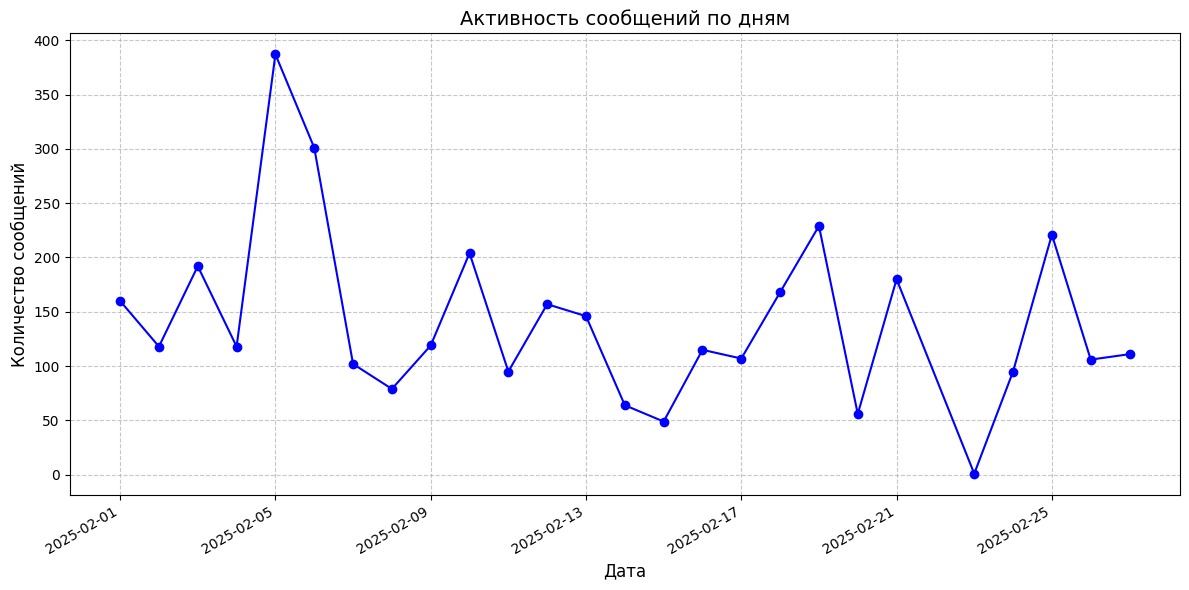

In [34]:
# Группируем по дате и считаем количество сообщений
daily_counts = df['date'].dt.floor('D').value_counts().sort_index()

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='o', color='blue', linestyle='-')

# Добавляем подписи
plt.title('Активность сообщений по дням', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество сообщений', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Построения линейного графика активности сообщений за один день без агрегации**

C:\Users\Виталик\AppData\Local\Temp\ipykernel_6320\89590428.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


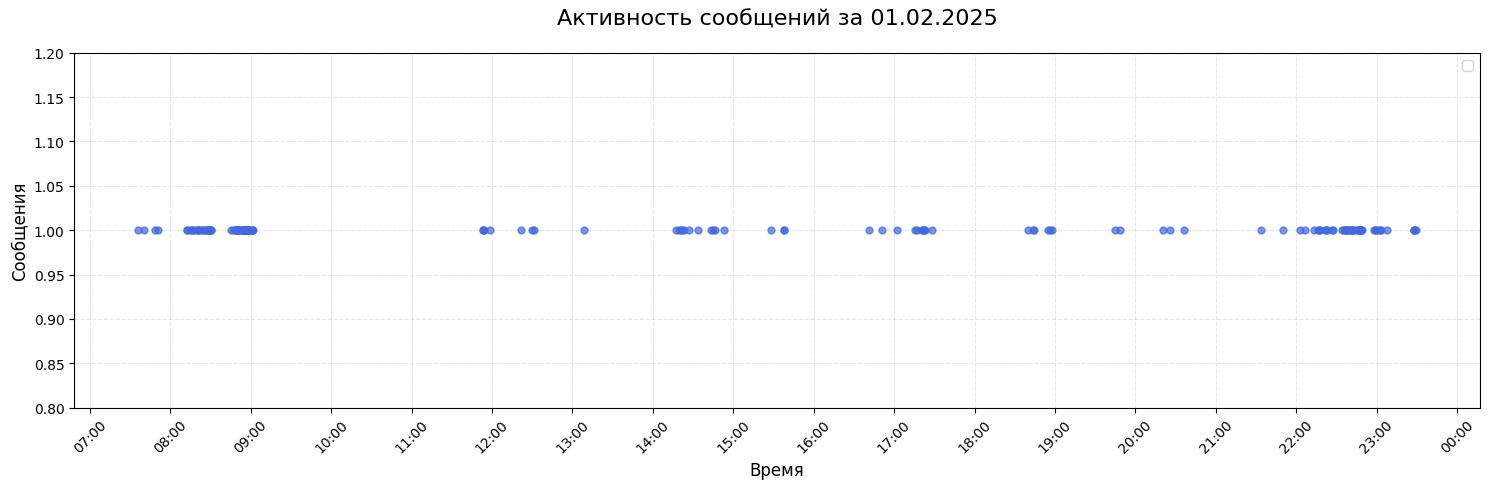

In [35]:
# Выбираем только первый день
first_day = df['date'].dt.date.min()
df_day = df[df['date'].dt.date == first_day].copy()

# Настройка стиля
plt.figure(figsize=(15, 5))

# Создаем график
ax = plt.gca()

# Вариант 1: Точечный график (каждое сообщение как точка)
ax.plot(df_day['date'],
        [1]*len(df_day),  # Все точки на y=1
        marker='o',
        markersize=5,
        linestyle='',
        alpha=0.7,
        color='royalblue')

# Настройка временной оси
ax.xaxis.set_major_locator(HourLocator(interval=1))  # Основные деления - каждый час
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Формат времени

# Подписи и оформление
plt.title(f'Активность сообщений за {first_day.strftime("%d.%m.%Y")}', fontsize=16, pad=20)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Сообщения', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.ylim(0.8, 1.2)  # Для точечного графика

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Выбираю пороговое значения - 30 минут

In [36]:
threshold_vspl = 30

In [37]:
# Добавляю пары соседних сообщений с порогом в 30 минут (в прошлом методе было 30 секунд)
# Порог выбрал вручную, глядя на графики активности сообщений
threshold_vspl = 30
y = []
for i in range(len(df)-1):
  if df.loc[i+1, 'date']-df.loc[i, 'date'] < pd.Timedelta(minutes=threshold_vspl):
    y.append([df.loc[i, 'message_id'], df.loc[i+1, 'message_id']])
len(y)

3466

In [38]:
para_vspl = pd.DataFrame(y, columns=['one','two'])
para_vspl

,one,two
0,42471,42472
1,42472,42473
2,42473,42474
3,42474,42475
4,42475,42476
...,...,...
3461,46399,46400
3462,46400,46401
3463,46401,46402
3464,46402,46403


In [39]:
# Составляем списки id сообщений в диалоги с помощью networkx
G = nx.Graph()
for _, row in para_vspl.iterrows():
    G.add_edge(row['one'], row['two'])
connected_components = list(nx.connected_components(G))
result_vspl = [sorted(list(component)) for component in connected_components]
result_vspl.sort(key=lambda x: x[0])
print(result_vspl[1:3])

[[np.int64(42543), np.int64(42544), np.int64(42545), np.int64(42546), np.int64(42547), np.int64(42548), np.int64(42549)], [np.int64(42554), np.int64(42555), np.int64(42556), np.int64(42557), np.int64(42558), np.int64(42559), np.int64(42560), np.int64(42561), np.int64(42562), np.int64(42563), np.int64(42564)]]


In [40]:
# Количество диалогов
len(result_vspl)

153

In [41]:
# Количество сообщений попавших в диалоги
total_vspl = sum(len(sublist) for sublist in result_vspl)
total_vspl

3619

In [42]:
# Количество сообщенией в наибольшем диалоге
total_vspl = max(len(sublist) for sublist in result_vspl)
total_vspl

206

In [43]:
# Сортирую
result_vspl_sorted = sorted(result_vspl, key=lambda x: len(x), reverse=True)
result_vspl_sorted_top = result_vspl_sorted[0:10]

In [44]:
# Отображаю 10 место
cluster_vspl_10 = df.loc[df['message_id'].isin(result_vspl_sorted_top[9]), 'text']#.tolist()
print('Количество сообщений в диалоге ', len(cluster_vspl_10))
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    print(cluster_vspl_10)

Количество сообщений в диалоге  79
2565                                                                                                                                                                                                                                                   Через гтм?
2566                                                                                                                                                                                                                                          Через oncontextmenu
2567                                                                                                                                                                                                                   Очень интересно, но не понятно 😂👍пример бы
2568                                                                                                                                                                                           

Вывод:
* Провел кластеризацию по всплескам активности. Порог по временногу интервалу между соседними сообщениями 30 минут.
* Порог по времени 30 минут. Этот порог выбрал после анализа графиков активности
* Собрал диалоги(кластеры) из 3466 связей(пар)
* 3619 сообщений (из 3680) попали в диалоги
* Получил 153 диалога.
* Выделил самые длинные (10шт).
* 206 собщения в самом большом, 79 в маленьком.
* Метрику оценил пока только визульно(почитал сообщения в диалоге). Связь между сообщениями прослеживается.

# Оценка и сравнение двух методов

Оценил по одному кластеру с помощью DeepSeek.

## Метод №1 кластер 10 - 51 сообщение

Запрос: Какую основную тему можно выделить в этом диалоге? + cluster_10

Результат: Основная тема диалога — проблема ботов и мусорного трафика в рекламных кампаниях, а также методы борьбы с ними.

Запрос: Сколько сообщений из этого диалога относятся к теме: проблема ботов и мусорного трафика в рекламных кампаниях, а также методы борьбы с ними. + cluster_10

Результат из 51 сообщения:
* 16 сообщений напрямую относятся к теме проблемы ботов, мусорного трафика и методов борьбы с ними.
* 22 сообщения релевантны
* остальные носят сопутствующий или оффтопный характер. (например, про креативы на грани фола, критику маркетологов-гуманитариев)

## Метод №2 кластер 10 - 79 сообщений

Запрос: Какую основную тему можно выделить в этом диалоге? + cluster_10

Результат: Технические аспекты настройки аналитики и рекламы

Запрос: Сколько сообщений из этого диалога относятся к теме: проблема ботов и мусорного трафика в рекламных кампаниях, а также методы борьбы с ними. + cluster_10

Результат из 79 сообщения:
* 24 сообщений напрямую относятся к теме проблемы ботов, мусорного трафика и методов борьбы с ними.
* 36 сообщений релевантны
* остальные оффтоп или другие темы.

# Вывод

Вывод: Оценил по одному кластеру с помощью DeepSeek. Также оценил кластеры вручную. Оба метода работают хорошо. Имеем четко сформулированную тему, практически все сообщения из кластера так или иначе в теме участвуют. Мне нравится результат Метода № 1. Кластеры поменьше и подход мне кажется получьше.  

Приемущество предствленного подхода для кластеризации:
* не используем машинное обучение
* точность (не доказано)
* простота реализации и интерпретируемость

Для нашей задачи считаю приемлем использование Метода №1.

# Доработка и оценка качества кластеризации Метода №1

## th_minute этот параметр зависит от плотности

В первом методе мы использовали порог в 30 секунд, найденый вручную на данном датасете. Этот параметр должен быть универсальным. При пороге в 30 секунд мы получbли вот такое количество связей (без реплай):

In [45]:
x = []
th_minute=0.5
for i in range(len(df)-1):
  if df.loc[i+1, 'date']-df.loc[i, 'date'] < pd.Timedelta(minutes=th_minute):
    x.append([df.loc[i, 'message_id'], df.loc[i+1, 'message_id']])
len(x)

1523

In [46]:
# Вычислим процент от всего количества сообщений
perc = round(len(x)/len(df), 2)*100
perc

41.0

In [47]:
# вычеслим полученый перцентиль на списке временных итервалов всех сообщений
pl = []
for i in range(len(df)-1):
   time_diff = df.loc[i+1, 'date']-df.loc[i, 'date']
   seconds = time_diff.total_seconds()
   pl.append(seconds)
percentile_int = int(np.percentile(pl, perc))
# выразим в минутах
th_minute = percentile_int/60
th_minute

0.48333333333333334

In [48]:
# Занаво соберем кластеры
x = []
for i in range(len(df)-1, -1, -1):
  if not pd.isna(df.loc[i, 'reply_to_message_id']):
    x.append([df.loc[i, 'message_id'], df.loc[i, 'reply_to_message_id']])
for i in range(len(df)-1):
  if df.loc[i+1, 'date']-df.loc[i, 'date'] < pd.Timedelta(minutes=th_minute):
    x.append([df.loc[i, 'message_id'], df.loc[i+1, 'message_id']])
para = pd.DataFrame(x, columns=['one','two'])
G = nx.Graph()
for _, row in para.iterrows():
    G.add_edge(row['one'], row['two'])
connected_components = list(nx.connected_components(G))
result = [sorted(list(component)) for component in connected_components]
result.sort(key=lambda x: x[0])
sorted_result = sorted(result, key=lambda x: len(x), reverse=True)

## Соберем датасет с важными признаками

### Столбец с номером кластера

In [49]:
df_clast = df[['message_id', 'text']]

In [50]:
len(sorted_result)

347

In [51]:
df_clast = df_clast.copy()
df_clast.loc[:, 'n_claster'] = np.nan
df_clast

,message_id,text,n_claster
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",NaN
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN
2,42473,"Если смотреть по интересам, то кажется, что ау...",NaN
3,42474,А путь пользователя почему-то выглядит так. Ко...,NaN
4,42475,Опять он,NaN
...,...,...,...
3675,46400,"Напишу им, спасибо.",NaN
3676,46401,"Старые профили не удаляются, номер на который ...",NaN
3677,46402,Пишите оператору (позовите пожалуйста оператор...,NaN
3678,46403,Отлично! Благодарю.,NaN


In [52]:
# Создаем словарь для быстрого поиска кластера по message_id
cluster_mapping = {}
for cluster_idx, cluster in enumerate(sorted_result):
    for message_id in cluster:
        cluster_mapping[float(message_id)] = cluster_idx  # преобразуем np.float64 в float

# Заполняем столбец n_claster
df_clast.loc[:, 'n_claster'] = df_clast['message_id'].map(cluster_mapping)

# Если какие-то message_id не найдены в кластерах, они останутся NaN
df_clast

,message_id,text,n_claster
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",42.0
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN
2,42473,"Если смотреть по интересам, то кажется, что ау...",141.0
3,42474,А путь пользователя почему-то выглядит так. Ко...,42.0
4,42475,Опять он,197.0
...,...,...,...
3675,46400,"Напишу им, спасибо.",117.0
3676,46401,"Старые профили не удаляются, номер на который ...",117.0
3677,46402,Пишите оператору (позовите пожалуйста оператор...,248.0
3678,46403,Отлично! Благодарю.,248.0


In [53]:
# проверка
len(df_clast.query('n_claster == 9'))

51

In [54]:
cluster_10 = df.loc[df['message_id'].isin(sorted_result[9]), 'text']#.tolist()
print('Количество сообщений в диалоге ', len(cluster_10))

Количество сообщений в диалоге  51


### Столбец с количеством сообщений в кластере

In [55]:
# Создаем и добавляем столбец с размерами кластеров
cluster_sizes = {i: len(cluster) for i, cluster in enumerate(sorted_result)}
df_clast.loc[:, 'cluster_size'] = df_clast['n_claster'].map(cluster_sizes)
df_clast

,message_id,text,n_claster,cluster_size
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",42.0,23.0
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN,NaN
2,42473,"Если смотреть по интересам, то кажется, что ау...",141.0,5.0
3,42474,А путь пользователя почему-то выглядит так. Ко...,42.0,23.0
4,42475,Опять он,197.0,3.0
...,...,...,...,...
3675,46400,"Напишу им, спасибо.",117.0,8.0
3676,46401,"Старые профили не удаляются, номер на который ...",117.0,8.0
3677,46402,Пишите оператору (позовите пожалуйста оператор...,248.0,3.0
3678,46403,Отлично! Благодарю.,248.0,3.0


### Столбец с количеством связей у сообщения

In [56]:
para

,one,two
0,46405,46403.0
1,46403,46402.0
2,46401,46394.0
3,46398,46396.0
4,46396,46394.0
...,...,...
3765,46395,46396.0
3766,46396,46397.0
3767,46397,46398.0
3768,46398,46399.0


In [57]:
# Считаем вхождения каждого ID в обоих столбцах
counts_one = para['one'].value_counts()
counts_two = para['two'].value_counts()

# Объединяем счетчики (складываем значения для одинаковых ID)
total_counts = counts_one.add(counts_two, fill_value=0).astype(int)

# Добавляем новый столбец в исходный датафрейм
para['connection_count'] = para['one'].map(total_counts)

In [58]:
para

,one,two,connection_count
0,46405,46403.0,1
1,46403,46402.0,2
2,46401,46394.0,1
3,46398,46396.0,3
4,46396,46394.0,4
...,...,...,...
3765,46395,46396.0,2
3766,46396,46397.0,4
3767,46397,46398.0,2
3768,46398,46399.0,3


In [59]:
# Добавляем счетчик связей в df_clast
df_clast.loc[:,'connection_count'] = df_clast['message_id'].map(total_counts)
df_clast

,message_id,text,n_claster,cluster_size,connection_count
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",42.0,23.0,2.0
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN,NaN,NaN
2,42473,"Если смотреть по интересам, то кажется, что ау...",141.0,5.0,1.0
3,42474,А путь пользователя почему-то выглядит так. Ко...,42.0,23.0,1.0
4,42475,Опять он,197.0,3.0,2.0
...,...,...,...,...,...
3675,46400,"Напишу им, спасибо.",117.0,8.0,1.0
3676,46401,"Старые профили не удаляются, номер на который ...",117.0,8.0,1.0
3677,46402,Пишите оператору (позовите пожалуйста оператор...,248.0,3.0,1.0
3678,46403,Отлично! Благодарю.,248.0,3.0,2.0


<Axes: >

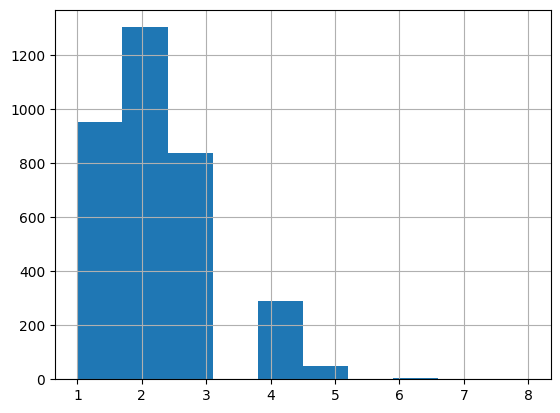

In [60]:
df_clast['connection_count'].hist()

In [61]:
df_clast.query('n_claster == 1 & connection_count > 2')['text']

509    Ребят, привет!\n\nМожет кто знает, участвовал ...
512    Интересно. А в чем собственно сложность? Слишк...
583      Привет, Влад. Предлагаю самим запустить хакатон
586                                    Хахатон запустите
587      Запускаю, кручу верчу, запутать хочу хахахаха 😀
588                      Ахалай Махалай Ляськи Масяськи?
589            И если не дунуть - то чуда не произойдет?
591                                    Крутите барабан 😁
596    [{'type': 'bold', 'text': '⚡️ Kingdom Come: De...
599    Первая часть была супер, уверен, вторая тоже с...
600    На рутьюбе ща даже конкурс по ворлд оф тенкс, ...
601                          Спасибо тебе мил человек 🙌🏻
602                          Но это прям зашквар же жуть
799                                          Скачал блин
803    Так, а зачем ты решил ее себе поставить? Пока ...
806                                       Кого? Игрушку?
807    Блин, я думал ты решил китайскую нейросетку у ...
808                            

In [62]:
filtered_messages = df_clast.query('n_claster == 1 & connection_count > 2')['text']
messages = "\n".join([str(msg) if not isinstance(msg, str) else msg for msg in filtered_messages])

prompt = f"""
Проанализируй следующие сообщения из одного кластера и определи основную тему диалога.
Сообщения должны иметь общую тематику, так как они попали в один кластер. Напиши только основную тему. Без пояснений.

Сообщения:
{messages}

Основная тема диалога:
"""

response = ollama.generate(model="llama3:8b", prompt=prompt)
print(response['response'])

Игры (Kingdom Come: Deliverance 2, Skyrim)


In [63]:
df_clast_filtred = df_clast.query('connection_count > 2')
df_clast_filtred

,message_id,text,n_claster,cluster_size,connection_count
6,42477,Потому и выбрал,141.0,5.0,3.0
11,42482,"Что такое Яндекс Игры? Я вот сижу, работаю, пр...",42.0,23.0,3.0
15,42487,"Ок. А как тогда получается, что пользователь о...",42.0,23.0,3.0
16,42488,В смысле?,42.0,23.0,3.0
19,42491,Если Яндекс Игры открыли для ребенка на телефо...,42.0,23.0,3.0
...,...,...,...,...,...
3661,46385,Можно. Буду благодарен. Освою что-То новое.,74.0,14.0,5.0
3662,46386,Только тг аккаунты и прокси сам покупай они та...,74.0,14.0,3.0
3669,46394,"Коллеги, вопрос такой. У компании есть забытый...",117.0,8.0,3.0
3671,46396,Через поддержку вроде все,117.0,8.0,4.0


In [65]:
clusters = df_clast_filtred.groupby('n_claster')['text'].apply(list).reset_index()

In [66]:
clusters

,n_claster,text
0,0.0,"[Коллеги, добры день, за советом. \nВзяли РК, ..."
1,1.0,"[Ребят, привет!\n\nМожет кто знает, участвовал..."
2,2.0,[А пока я одну расскажу\n\nРоскомнадзор будет ...
3,3.0,"[, Чувствую этот запах), Как будто там огонь п..."
4,4.0,"[Правило действительно хорошее, думаю последую..."
...,...,...
162,207.0,"[Тут надо аккуратней силы рассчитывать, а то к..."
163,208.0,"[То есть половина данных потеряется, а может и..."
164,213.0,[Хочешь отучиться?]
165,222.0,[Площадку добавляли (вк) или она сама туда поп...


In [62]:
# 2. Определим функцию для получения темы от LLM
def get_cluster_topic(messages):
    # Преобразуем сообщения в строку, учитывая что они могут быть списками
    if isinstance(messages, list):
        # Если это список, соединяем все элементы
        processed_text = ' '.join([str(item) if not isinstance(item, dict) else item.get('text', '') for item in messages])
    else:
        processed_text = str(messages)

    prompt = f"""
    Проанализируй следующие сообщения из одного кластера и определи основную тему диалога.
    Сообщения должны иметь общую тематику, так как они попали в один кластер. Напиши только основную тему. Без пояснений.

    Сообщения:
    {processed_text}

    Основная тема диалога:
    """

    try:
        response = ollama.generate(
            model="llama3:8b",
            prompt=prompt,
            options={'temperature': 0.3} # Для более консервативных ответов
        )
        return response['response'].strip()
    except Exception as e:
        print(f"Ошибка для кластера: {e}")
        return "Не определена"

In [63]:
clusters['text'].iloc[1:3]
fff = clusters['text'].iloc[1:3].apply(get_cluster_topic)
print(fff)

1                      Игры (RPG)
2    Роскомнадзор и киберразведка
Name: text, dtype: object


In [64]:
# 3. Получим темы для каждого кластера
clusters['topic'] = clusters['text'].apply(get_cluster_topic)
# 4. Объединим результаты с исходным датафреймом
df_clast = df_clast.merge(
    clusters[['n_claster', 'topic']],
    on='n_claster',
    how='left'
)

In [65]:
df_clast

,message_id,text,n_claster,cluster_size,connection_count,topic
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",42.0,23.0,2.0,Яндекс Игры
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN,NaN,NaN,NaN
2,42473,"Если смотреть по интересам, то кажется, что ау...",141.0,5.0,1.0,Выбор
3,42474,А путь пользователя почему-то выглядит так. Ко...,42.0,23.0,1.0,Яндекс Игры
4,42475,Опять он,197.0,3.0,2.0,NaN
...,...,...,...,...,...,...
3675,46400,"Напишу им, спасибо.",117.0,8.0,1.0,Удаление профиля в Яндексе и создание нового.
3676,46401,"Старые профили не удаляются, номер на который ...",117.0,8.0,1.0,Удаление профиля в Яндексе и создание нового.
3677,46402,Пишите оператору (позовите пожалуйста оператор...,248.0,3.0,1.0,NaN
3678,46403,Отлично! Благодарю.,248.0,3.0,2.0,NaN


In [66]:

# 5. Для сообщений без кластера заполним тему
df_clast['topic'] = df_clast['topic'].fillna('Неизвестная тема')

In [67]:
df_clast

,message_id,text,n_claster,cluster_size,connection_count,topic
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",42.0,23.0,2.0,Яндекс Игры
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN,NaN,NaN,Неизвестная тема
2,42473,"Если смотреть по интересам, то кажется, что ау...",141.0,5.0,1.0,Выбор
3,42474,А путь пользователя почему-то выглядит так. Ко...,42.0,23.0,1.0,Яндекс Игры
4,42475,Опять он,197.0,3.0,2.0,Неизвестная тема
...,...,...,...,...,...,...
3675,46400,"Напишу им, спасибо.",117.0,8.0,1.0,Удаление профиля в Яндексе и создание нового.
3676,46401,"Старые профили не удаляются, номер на который ...",117.0,8.0,1.0,Удаление профиля в Яндексе и создание нового.
3677,46402,Пишите оператору (позовите пожалуйста оператор...,248.0,3.0,1.0,Неизвестная тема
3678,46403,Отлично! Благодарю.,248.0,3.0,2.0,Неизвестная тема


In [68]:
clusters[['n_claster', 'topic']]

,n_claster,topic
0,0.0,Маркетинг и реклама
1,1.0,Игры (RPG)
2,2.0,Мониторинг и контроль граждан
3,3.0,Ностальгия по компьютерам и интернету 90-х годов.
4,4.0,Бизнес/Продвижение
...,...,...
162,207.0,Финансы/Бюджет
163,208.0,Данные/информация
164,213.0,Образование
165,222.0,Вопросы о социальных сетях


In [ ]:
# Экспорт DataFrame в Excel файл
df_clast.to_excel('df_clast.xlsx', index=False, engine='openpyxl')

print("Файл успешно сохранён: df_clast.xlsx")

Файл успешно сохранён: df_clast.xlsx


In [ ]:
# Экспорт DataFrame в Excel файл
clusters[['n_claster', 'topic']].to_excel('clusters.xlsx', index=False, engine='openpyxl')

print("Файл успешно сохранён: clusters.xlsx")

Файл успешно сохранён: clusters.xlsx


# Вывод

1. На основе метода №1 провел кластеризацию
2. Собрал Датафрейм
    * message_id
    * text
    * n_claster - номер кластера от  0 по количеству сообщений в кластере (нулевой самый большой)
    * cluster_size - количество сообщений в кластере
    * connection_count - количество связей сообщение с другими сообщениями
    * topic - название темы диалога.
Название темы диалога заполнил на основе работы llama3:8b (код выполнялся примерно 10 минут)
Запрос:  'Проанализируй следующие сообщения из одного кластера и определи основную тему диалога.
    Сообщения должны иметь общую тематику, так как они попали в один кластер. Напиши только основную тему. Без пояснений.  

    Сообщения:
    {messages}

    Основная тема диалога:'  
В качестве сообщений подовались соошения: серия сообщений message преобразованная в строку "как есть".  
Предворительно сообщения были отфильтрованы по признаку количество связей больше двух.  
Температура модели: Пониженная температура (0.3) для более предсказуемых ответов  

В результате создал два файла в Excel. Основной датафрейм и список названий кластеров.

# Призентация метода

Суть метода: Необходимо выделить в диалоги сообщения, связанные между собой с помощью механики reply. Также добавить в эти диалоги соседние сообщения с маленьким временным порогом. Я использовал для этого чата th_minute=0.5. Связь это два связонных по методике метода сообщения.
1. Парсинг  
2. Кластеризация:
  * Провел кластеризацию по reply и по соседним сообщениям с временным threshold`ом.
  * Порог по времени пол минуты. Это порог выбрал вручную сравнивая с количеством полученных пар. При этом пороге 1500 пар из датасета в 3680
  * Собрал диалоги(кластеры) из 3809 связей(пар)
  * 3459 сообщение (из 3680) попали в диалоги
  * Получил 341 диалог.
  * Выделил самые длинные (10шт).
  * 103 собщения в самом большом, 51 в маленьком.
  * Метрику оценил пока только визульно(почитал сообщения в диалоге). Связь между сообщениями прослеживается.
3. Название тем диалога:  
 3.1 Собрал Датафрейм
    * message_id
    * text
    * n_claster - номер кластера от  0 по количеству сообщений в кластере (нулевой самый большой)
    * cluster_size - количество сообщений в кластере
    * connection_count - количество связей сообщение с другими сообщениями
    * topic - название темы диалога.
  
Название темы диалога заполнил на основе работы llama3:8b (запрос выполнялся примерно 10 минут)  
Запрос:  "Проанализируй следующие сообщения из одного кластера и определи основную тему диалога. Сообщения должны иметь общую тематику, так как они попали в один кластер. Напиши только основную тему. Без пояснений. Сообщения:  {messages} Основная тема диалога:"  
* В качестве сообщений подовались соошения: серия сообщений message преобразованная в строку "как есть".  
* Предворительно сообщения были отфильтрованы по признаку количество связей больше двух.  
* Температура модели: Пониженная температура (0.3) для более предсказуемых ответов  

В результате создал два файла в Excel. Основной датафрейм и список названий кластеров.  
Пример из датафрейма:



In [ ]:
df_clast

,message_id,text,n_claster,cluster_size,connection_count,topic
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",42.0,23.0,2.0,Яндекс Игры
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN,NaN,NaN,Неизвестная тема
2,42473,"Если смотреть по интересам, то кажется, что ау...",141.0,5.0,1.0,Выбор
3,42474,А путь пользователя почему-то выглядит так. Ко...,42.0,23.0,1.0,Яндекс Игры
4,42475,Опять он,197.0,3.0,2.0,Неизвестная тема
...,...,...,...,...,...,...
3675,46400,"Напишу им, спасибо.",117.0,8.0,1.0,Удаление забытого профиля в Яндексе и создание...
3676,46401,"Старые профили не удаляются, номер на который ...",117.0,8.0,1.0,Удаление забытого профиля в Яндексе и создание...
3677,46402,Пишите оператору (позовите пожалуйста оператор...,248.0,3.0,1.0,Неизвестная тема
3678,46403,Отлично! Благодарю.,248.0,3.0,2.0,Неизвестная тема


Пример списка названий кластеров:

In [ ]:
clusters[['n_claster', 'topic']]

,n_claster,topic
0,0.0,Реклама и маркетинг
1,1.0,"РPG игры (Kingdom Come: Deliverance 2, Skyrim)"
2,2.0,Битрикс
3,3.0,Компьютеры и интернет.
4,4.0,Бизнес/экономика
...,...,...
162,207.0,Финансы/Бюджет
163,208.0,Качество данных
164,213.0,Образование
165,222.0,Местоположение/география


Приемущество предствленного подхода:
* не используем машинное обучение при кластеризации
* точность (не доказано). Логика что сообщения участвуют в одном диалоге через reply очивидна. Логика что сообщения близкие к друг другу по времени (~30 секунд) будут в одном диалоге имеет высокую вероятность.
* простота реализации и интерпретируемость  

Недостатки:
* очень много диалогов на выходе, нужен фильтр по рейтингу для дайджеста
* Некотрые полученные диалоги могут быть на одну и ту же тему или даже по сути быть в одном диалоге, но в результате данной обработки разнесены в разные кластеры
* есть вероятность, что сообщения через механику reply сгруппируются в один диалог, а на самом деле в определенный момент после некоторго количиства последовательных реплаев тема разговора плавно поменятеся с одной на другую   

Что можно доработать:
* Для уточнения рейтинга диалогов помимо количества сообщений можно использовать количество реакций на на сообщения в диалоге
* Темы диалогов представлены короткими фразами, это можно расширить до двух предложений
* Запросить у LLM добавить описание диалога, раскрыть его суть в коротком тексте.

Вопрос: почему я не захотел использовать модели машинного обучения для определения кластеров?  
Ответ:
* по ембендингам модель сможет отнести к класу только если уже есть готовые составленные темы
* если выделять тему деалога по одному сообщению. Не с каждым сообщением это получется. В чате есть мусорные сообщения, сообщения которые раскрывает тему только в совокупности а не по отдельности.
* возможно качества моего метода будет достаточно для текущей задачи (вопрос к заказчику)
* идея моего метода является прекрасной альтернативой для сравнения с результатами других участников проекта. А также может вдохновить на новые решения поставленной задачи.

# Доработка и отладка готового решения

## Метрика полученных кластеров

In [ ]:
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer

c:\Users\Виталик\Desktop\Pro\Pet\Telegram_Bot\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Загружаем модель для эмбеддингов
encoder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [ ]:
df_clast

,message_id,text,n_claster,cluster_size,connection_count,topic
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",42.0,23.0,2.0,Яндекс Игры
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN,NaN,NaN,Неизвестная тема
2,42473,"Если смотреть по интересам, то кажется, что ау...",141.0,5.0,1.0,Выбор
3,42474,А путь пользователя почему-то выглядит так. Ко...,42.0,23.0,1.0,Яндекс Игры
4,42475,Опять он,197.0,3.0,2.0,Неизвестная тема
...,...,...,...,...,...,...
3675,46400,"Напишу им, спасибо.",117.0,8.0,1.0,Удаление забытого профиля в Яндексе и создание...
3676,46401,"Старые профили не удаляются, номер на который ...",117.0,8.0,1.0,Удаление забытого профиля в Яндексе и создание...
3677,46402,Пишите оператору (позовите пожалуйста оператор...,248.0,3.0,1.0,Неизвестная тема
3678,46403,Отлично! Благодарю.,248.0,3.0,2.0,Неизвестная тема


In [ ]:
def evaluate_clusters(df):
    # Фильтруем сообщения с определенными кластерами
    filtered = df[df['n_claster'].notna()]
    texts = filtered['text'].tolist()
    labels = filtered['n_claster'].astype(int).tolist()
    
    # Считаем эмбеддинги
    embeddings = encoder.encode(texts)
    
    # Оцениваем силу кластеризации
    score = silhouette_score(embeddings, labels)
    print(f"Silhouette Score: {score:.2f} (чем ближе к 1, тем лучше)")
    
    # Пример вывода: "Silhouette Score: 0.45"

In [ ]:
evaluate_clusters(df_clast)

Silhouette Score: -0.25 (чем ближе к 1, тем лучше)


Вывод:  
Попытался оценить метрику  
Silhouette Score — метрика, которая оценивает:  
Насколько близки объекты внутри одного кластера (когезия).  
Насколько далеко они от объектов других кластеров (сепарация).  
Результат плохо оцениваемый. Помню, что в диалогах имеет значение совокупность сообщение, а не одиночки.

## Для уточнения рейтинга кластеров добавим реакции.

In [ ]:
# Добавил в парсинг reaction_count
parsed_messages = []
for message in messages:
    if message.get('type') == 'message':
        text = message['text']
        reactions = message.get('reactions', [])
        reaction_count = sum(reaction.get('count', 0) for reaction in reactions) if reactions else 0
        parsed_messages.append({
            'message_id': message['id'],
            'date': message['date'],
            'chat_name': chat_name,
            'chat_id': chat_id,
            'sender_id': message.get('from_id'),
            'from': message.get('from', 'Unknown'),
            'reply_to_message_id': message.get('reply_to_message_id'),
            'text': text,
            'reaction_count': reaction_count
        })

In [ ]:
df = pd.DataFrame(parsed_messages)
df

,message_id,date,chat_name,chat_id,sender_id,from,reply_to_message_id,text,reaction_count
0,42471,2025-02-01T07:35:54,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",0
1,42472,2025-02-01T07:40:03,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,"А вот регионы, в которых живут ITшники с интер...",0
2,42473,2025-02-01T07:48:53,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,"Если смотреть по интересам, то кажется, что ау...",0
3,42474,2025-02-01T07:50:31,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,А путь пользователя почему-то выглядит так. Ко...,0
4,42475,2025-02-01T08:12:42,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,NaN,Опять он,0
...,...,...,...,...,...,...,...,...,...
3675,46400,2025-02-27T20:11:04,💬 Marketing Practicum Chat,1782474569,user1829741608,Алексей Ермолов,NaN,"Напишу им, спасибо.",0
3676,46401,2025-02-27T20:23:08,💬 Marketing Practicum Chat,1782474569,user1912824918,S,46394.0,"Старые профили не удаляются, номер на который ...",1
3677,46402,2025-02-27T20:24:44,💬 Marketing Practicum Chat,1782474569,user1912824918,S,NaN,Пишите оператору (позовите пожалуйста оператор...,1
3678,46403,2025-02-27T20:29:44,💬 Marketing Practicum Chat,1782474569,user1829741608,Алексей Ермолов,46402.0,Отлично! Благодарю.,0


In [ ]:
max(df['reaction_count'])

11

In [ ]:
df_clast['reaction_count'] = df['reaction_count']
df_clast

,message_id,text,n_claster,cluster_size,connection_count,topic,reaction_count
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",42.0,23.0,2.0,Яндекс Игры,0
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN,NaN,NaN,Неизвестная тема,0
2,42473,"Если смотреть по интересам, то кажется, что ау...",141.0,5.0,1.0,Выбор,0
3,42474,А путь пользователя почему-то выглядит так. Ко...,42.0,23.0,1.0,Яндекс Игры,0
4,42475,Опять он,197.0,3.0,2.0,Неизвестная тема,0
...,...,...,...,...,...,...,...
3675,46400,"Напишу им, спасибо.",117.0,8.0,1.0,Удаление забытого профиля в Яндексе и создание...,0
3676,46401,"Старые профили не удаляются, номер на который ...",117.0,8.0,1.0,Удаление забытого профиля в Яндексе и создание...,1
3677,46402,Пишите оператору (позовите пожалуйста оператор...,248.0,3.0,1.0,Неизвестная тема,1
3678,46403,Отлично! Благодарю.,248.0,3.0,2.0,Неизвестная тема,0


In [ ]:
# Создаем словарь для хранения суммы реакций по кластерам
cluster_reactions = df_clast.groupby('n_claster')['reaction_count'].sum().to_dict()

# Добавляем столбец с рейтингом кластера
df_clast['cluster_rating'] = df_clast.apply(
    lambda row: row['cluster_size'] + cluster_reactions.get(row['n_claster'], 0) 
    if pd.notna(row['n_claster']) else np.nan,
    axis=1
)
df_clast

,message_id,text,n_claster,cluster_size,connection_count,topic,reaction_count,cluster_rating
0,42471,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы...",42.0,23.0,2.0,Яндекс Игры,0,26.0
1,42472,"А вот регионы, в которых живут ITшники с интер...",NaN,NaN,NaN,Неизвестная тема,0,NaN
2,42473,"Если смотреть по интересам, то кажется, что ау...",141.0,5.0,1.0,Выбор,0,6.0
3,42474,А путь пользователя почему-то выглядит так. Ко...,42.0,23.0,1.0,Яндекс Игры,0,26.0
4,42475,Опять он,197.0,3.0,2.0,Неизвестная тема,0,4.0
...,...,...,...,...,...,...,...,...
3675,46400,"Напишу им, спасибо.",117.0,8.0,1.0,Удаление забытого профиля в Яндексе и создание...,0,10.0
3676,46401,"Старые профили не удаляются, номер на который ...",117.0,8.0,1.0,Удаление забытого профиля в Яндексе и создание...,1,10.0
3677,46402,Пишите оператору (позовите пожалуйста оператор...,248.0,3.0,1.0,Неизвестная тема,1,5.0
3678,46403,Отлично! Благодарю.,248.0,3.0,2.0,Неизвестная тема,0,5.0


In [ ]:
clusters

,n_claster,text,topic
0,0.0,"[Коллеги, добры день, за советом. \nВзяли РК, ...",Маркетинг и реклама
1,1.0,"[Ребят, привет!\n\nМожет кто знает, участвовал...","Игры (Kingdom Come: Deliverance 2, Skyrim)"
2,2.0,[А пока я одну расскажу\n\nРоскомнадзор будет ...,Реклама и интернет-маркетинг
3,3.0,"[, Чувствую этот запах), Как будто там огонь п...",Компьютеры и интернет.
4,4.0,"[Правило действительно хорошее, думаю последую...",Бизнес/Продвижение/Маркетинг
...,...,...,...
162,207.0,"[Тут надо аккуратней силы рассчитывать, а то к...",Финансы/Бюджет
163,208.0,"[То есть половина данных потеряется, а может и...",Потери данных
164,213.0,[Хочешь отучиться?],Учение/образование
165,222.0,[Площадку добавляли (вк) или она сама туда поп...,Социальные сети


In [ ]:
# Создаем словарь с рейтингами кластеров из df_clast
cluster_ratings = df_clast.groupby('n_claster')['cluster_rating'].first().to_dict()

# Добавляем столбец cluster_rating в clusters
clusters['cluster_rating'] = clusters['n_claster'].map(cluster_ratings)

# Заполняем NaN нулями (если кластер есть в clusters, но нет в df_clast)
clusters['cluster_rating'] = clusters['cluster_rating'].fillna(0)

In [ ]:
clusters = clusters.sort_values('cluster_rating', ascending=False)
clusters

,n_claster,text,topic,cluster_rating
0,0.0,"[Коллеги, добры день, за советом. \nВзяли РК, ...",Маркетинг и реклама,140.0
1,1.0,"[Ребят, привет!\n\nМожет кто знает, участвовал...","Игры (Kingdom Come: Deliverance 2, Skyrim)",124.0
3,3.0,"[, Чувствую этот запах), Как будто там огонь п...",Компьютеры и интернет.,98.0
2,2.0,[А пока я одну расскажу\n\nРоскомнадзор будет ...,Реклама и интернет-маркетинг,97.0
5,5.0,"[Добрый день. Демон версию нельзя посмотреть, ...",Социальные сети и интернет-культура.,95.0
...,...,...,...,...
161,203.0,[Почему завидовал?],Свойство человека (чувство зависти),4.0
163,208.0,"[То есть половина данных потеряется, а может и...",Потери данных,4.0
165,222.0,[Площадку добавляли (вк) или она сама туда поп...,Социальные сети,4.0
164,213.0,[Хочешь отучиться?],Учение/образование,3.0


## Запрос через батчи

In [ ]:
# 2. Определим функцию для обработки батча кластеров
def process_batch(batch_messages):
    """Обрабатывает батч из 5 сообщений и возвращает список тем"""
    batch_topics = []
    for messages in batch_messages:
        if isinstance(messages, list):
            processed_text = ' '.join([str(item) if not isinstance(item, dict) else item.get('text', '') 
                                    for item in messages])
        else:
            processed_text = str(messages)

        prompt = f"""
        Проанализируй следующие сообщения из одного кластера и определи основную тему диалога.
        Сообщения должны иметь общую тематику. Напиши только основную тему. Без пояснений.

        Сообщения:
        {processed_text}

        Основная тема диалога:
        """

        try:
            response = ollama.generate(
                model="llama3:8b",
                prompt=prompt,
                options={'temperature': 0.3}
            )
            topic = response['response'].strip().strip('"').split('\n')[0]
            batch_topics.append(topic)
        except Exception as e:
            print(f"\nОшибка при обработке кластера: {e}")
            batch_topics.append("Не определена")
    
    return batch_topics

# 3. Функция для батч-обработки
def process_in_batches(df, batch_size=5):
    """Обрабатывает DataFrame батчами"""
    all_topics = []
    total_batches = len(df) // batch_size + (1 if len(df) % batch_size else 0)
    
    for i in tqdm(range(0, len(df), batch_size), total=total_batches, desc="Обработка кластеров"):
        batch = df['text'].iloc[i:i+batch_size].tolist()
        batch_topics = process_batch(batch)
        all_topics.extend(batch_topics)
        time.sleep(1)  # небольшая пауза между батчами
        
    return all_topics

In [72]:
clusters['topic'] = process_in_batches(clusters)

Обработка кластеров: 100%|██████████| 34/34 [06:52<00:00, 12.14s/it]


In [70]:
clusters

,n_claster,text,topic
0,0.0,"[Коллеги, добры день, за советом. \nВзяли РК, ...",Маркетинг и реклама
1,1.0,"[Ребят, привет!\n\nМожет кто знает, участвовал...",Игры (RPG)
2,2.0,[А пока я одну расскажу\n\nРоскомнадзор будет ...,Мониторинг и контроль граждан
3,3.0,"[, Чувствую этот запах), Как будто там огонь п...",Ностальгия по компьютерам и интернету 90-х годов.
4,4.0,"[Правило действительно хорошее, думаю последую...",Бизнес/Продвижение
...,...,...,...
162,207.0,"[Тут надо аккуратней силы рассчитывать, а то к...",Финансы/Бюджет
163,208.0,"[То есть половина данных потеряется, а может и...",Данные/информация
164,213.0,[Хочешь отучиться?],Образование
165,222.0,[Площадку добавляли (вк) или она сама туда поп...,Вопросы о социальных сетях


In [73]:
clusters

,n_claster,text,topic
0,0.0,"[Коллеги, добры день, за советом. \nВзяли РК, ...",Маркетинг/Реклама
1,1.0,"[Ребят, привет!\n\nМожет кто знает, участвовал...",Игры
2,2.0,[А пока я одну расскажу\n\nРоскомнадзор будет ...,Битрикс
3,3.0,"[, Чувствую этот запах), Как будто там огонь п...",Технологии
4,4.0,"[Правило действительно хорошее, думаю последую...",Бизнес
...,...,...,...
162,207.0,"[Тут надо аккуратней силы рассчитывать, а то к...",Финансы
163,208.0,"[То есть половина данных потеряется, а может и...",Data Loss
164,213.0,[Хочешь отучиться?],Учение
165,222.0,[Площадку добавляли (вк) или она сама туда поп...,ВК


## Ключевые слова

In [80]:
clusters['text'][1]

['Ребят, привет!\n\nМожет кто знает, участвовал в челленджах/соревнованиях для маркетологов?\nа то у программистов целая куча этих соревнований, аж завидно',
 'Интересно. А в чем собственно сложность? Слишком мало мест? Отбор? Или иные факторы?',
 'Привет, Влад. Предлагаю самим запустить хакатон',
 'Хахатон запустите',
 'Запускаю, кручу верчу, запутать хочу хахахаха 😀',
 'Ахалай Махалай Ляськи Масяськи?',
 'И если не дунуть - то чуда не произойдет?',
 'Крутите барабан 😁',
 [{'type': 'bold',
   'text': '⚡️ Kingdom Come: Deliverance 2 ВЫШЛА сразу на торрентах '},
  '— в релизе нет антипиратской защиты, поэтому средневековая GTA уже ждёт в ',
  {'type': 'bold', 'text': '«зелёном стиме»'},
  '.\n\nИгру называют ЛУЧШЕЙ RPG года — она залутала безумные 87 баллов на Metacritic. Хвалят качественные квесты, кинематографичность, эпичную историю и глубоко детализованный средневековый мир.\n\nВнутри много хардкорных боёв, реки крови, расчленёнка и красивые дамы. А еще Kingdom Come: Deliverance 2 о

In [98]:
filtered_messages = clusters['text'][0]
messages = "\n".join([str(msg) if not isinstance(msg, str) else msg for msg in filtered_messages])

prompt = f"""
        [Инструкция]
        Проанализируй следующие сообщения из чата и выдели ровно 10 самых релевантных ключевых слов, 
        которые лучше всего характеризуют общую тему диалога. Слова должны быть:
        - существительными или короткими фразами (2-3 слова)
        - на русском языке
        - разделены запятыми
        - без кавычек и точек
        - без пояснений и дополнительного текста

        [Пример правильного ответа]
        маркетинг, реклама, Яндекс Директ, настройка, объявления, аудитория, таргетинг, бюджет, конверсия, CTR

        [Сообщения для анализа]
        {messages}

            """

response = ollama.generate(model="llama3:8b", prompt=prompt)
print(response['response'])

Реклама, Яндекс Директ, метрика, CRM, сайт, интернет-магазин, кабели, электричество, бюдж, конверсия, CTR, маркетинг, реклама в интернете, targeting, аудитория.


In [104]:
def process_batch_words(batch_messages):
    """Обрабатывает батч из 5 сообщений и возвращает списки ключевых слов"""
    batch_topics = []
    for messages in batch_messages:
        if isinstance(messages, list):
            processed_text = ' '.join([str(item) if not isinstance(item, dict) else item.get('text', '') 
                                    for item in messages])
        else:
            processed_text = str(messages)

        prompt = f"""
        [Инструкция]
        Анализируй сообщения и строго верни ровно 10 ключевых слов через запятую.
        Требования:
        1. Ровно 10 слов/фраз
        2. Только существительные или словосочетания (2-3 слова)
        3. Разделитель: запятая
        4. Без точек, кавычек, номеров и пояснений
        5. Если слов меньше 10 - дополни список общими словами из темы

        [Пример]
        маркетинг, реклама, Яндекс Директ, настройка, объявления, аудитория, таргетинг, бюджет, конверсия, CTR

        [Сообщения]
        {processed_text}

        [Ответ]
        """
        
        try:
            response = ollama.generate(
                model="llama3:8b",
                prompt=prompt,
                options={'temperature': 0.3}
            )
            topic = response['response'].strip().strip('"').split('\n')[0]
            batch_topics.append(topic)
        except Exception as e:
            print(f"\nОшибка при обработке кластера: {e}")
            batch_topics.append("Не определена")
    
    return batch_topics
    
 
# 3. Функция для батч-обработки
def process_in_batches_words(df, batch_size=5):
    """Обрабатывает DataFrame батчами"""
    all_topics = []
    total_batches = len(df) // batch_size + (1 if len(df) % batch_size else 0)
    
    for i in tqdm(range(0, len(df), batch_size), total=total_batches, desc="Обработка кластеров"):
        batch = df['text'].iloc[i:i+batch_size].tolist()
        batch_topics = process_batch_words(batch)
        all_topics.extend(batch_topics)
        time.sleep(1)  # небольшая пауза между батчами
        
    return all_topics

In [ ]:
clusters.iloc[1:6]

,n_claster,text,topic,words
1,1.0,"[Ребят, привет!\n\nМожет кто знает, участвовал...",Игры,Гейминг
2,2.0,[А пока я одну расскажу\n\nРоскомнадзор будет ...,Битрикс,Битрикс
3,3.0,"[, Чувствую этот запах), Как будто там огонь п...",Технологии,Технологии
4,4.0,"[Правило действительно хорошее, думаю последую...",Бизнес,Бизнес
5,5.0,"[Добрый день. Демон версию нельзя посмотреть, ...",Социальные сети,Друзья


In [105]:
fff = process_in_batches_words(clusters.iloc[1:6])
fff

Обработка кластеров: 100%|██████████| 1/1 [00:47<00:00, 47.68s/it]


['маркетинг, реклама, соревнования, хакатон, игры, RPG, мета-критик, оптимизация, компьютеры, лицензия',
 'информация, данные, аудитория, таргетинг, бюджет, конверсия, CTR, реклама, маркетинг, Роскомнадзор',
 'маркетинг, реклама, Яндекс Директ, настройка, объявления, аудитория, таргетинг, бюджет, конверсия, компьютер',
 'маркетинг, реклама, Яндекс Директ, настройка, объявления, аудитория, таргетинг, бюджет, конверсия, CTR',
 'маркетинг, реклама, Яндекс Директ, настройка, объявления, аудитория, таргетинг, бюджет, конверсия, потребности']

In [106]:
clusters['words'] = process_in_batches_words(clusters)

Обработка кластеров: 100%|██████████| 34/34 [21:23<00:00, 37.76s/it]


In [109]:
clusters

,n_claster,text,topic,words
0,0.0,"[Коллеги, добры день, за советом. \nВзяли РК, ...",Маркетинг/Реклама,"маркетинг, реклама, Яндекс Директ, настройка, ..."
1,1.0,"[Ребят, привет!\n\nМожет кто знает, участвовал...",Игры,"маркетинг, реклама, соревнования, хакатон, игр..."
2,2.0,[А пока я одну расскажу\n\nРоскомнадзор будет ...,Битрикс,"информация, данные, аудитория, безопасность, к..."
3,3.0,"[, Чувствую этот запах), Как будто там огонь п...",Технологии,"компьютер, комплектация, система, мусор, поряд..."
4,4.0,"[Правило действительно хорошее, думаю последую...",Бизнес,"маркетинг, реклама, Яндекс Директ, настройка, ..."
...,...,...,...,...
162,207.0,"[Тут надо аккуратней силы рассчитывать, а то к...",Финансы,"сила, пенсия, страхование, деньги, будущее, пл..."
163,208.0,"[То есть половина данных потеряется, а может и...",Data Loss,"данные, потеря, информация, половина, ничего, ..."
164,213.0,[Хочешь отучиться?],Учение,"образование, обучение, методы, программы, курс..."
165,222.0,[Площадку добавляли (вк) или она сама туда поп...,ВК,"социальные, платформы, площадка, добавление, к..."


## Суть диалога

In [ ]:
def process_batch_idea(batch_messages):
    """Обрабатывает батч из 5 сообщений и возвращает списки ключевых слов"""
    batch_topics = []
    for messages in batch_messages:
        if isinstance(messages, list):
            processed_text = ' '.join([str(item) if not isinstance(item, dict) else item.get('text', '') 
                                    for item in messages])
        else:
            processed_text = str(messages)

        prompt = f"""
        [Инструкция]
        Проанализируй следующие сообщения из чата и выдели главную мысль этого диалога, 
        напиши главную мысль на руском языке в виде 1-3 предложений. 
        Предложения должны быть:
        - на русском языке
        - без ковычек
        - без пояснений и дополнительного текста

        [Сообщения для анализа]
        {processed_text}

            """
        
        try:
            response = ollama.generate(
                model="llama3:8b",
                prompt=prompt,
                options={'temperature': 0.3}
            )
            topic = response['response'].strip().strip('"').split('\n')[0]
            batch_topics.append(topic)
        except Exception as e:
            print(f"\nОшибка при обработке кластера: {e}")
            batch_topics.append("Не определена")
    
    return batch_topics
    
 
# 3. Функция для батч-обработки
def process_in_batches_idea(df, batch_size=5):
    """Обрабатывает DataFrame батчами"""
    all_topics = []
    total_batches = len(df) // batch_size + (1 if len(df) % batch_size else 0)
    
    for i in tqdm(range(0, len(df), batch_size), total=total_batches, desc="Обработка кластеров"):
        batch = df['text'].iloc[i:i+batch_size].tolist()
        batch_topics = process_batch_idea(batch)
        all_topics.extend(batch_topics)
        time.sleep(1)  # небольшая пауза между батчами
        
    return all_topics

In [73]:
fff = process_in_batches_idea(clusters.iloc[1:2])
fff

Обработка кластеров: 100%|██████████| 1/1 [00:43<00:00, 43.64s/it]


['Главная мысль диалога: "Маркетологи нуждаются в соревнованиях и хакатонах, чтобы развивать свои навыки".']

In [74]:
clusters['idea'] = process_in_batches_idea(clusters)

Обработка кластеров: 100%|██████████| 34/34 [35:19<00:00, 62.34s/it]  


In [76]:
# Экспорт DataFrame в Excel файл
clusters.to_excel('clusters.xlsx', index=False, engine='openpyxl')

print("Файл успешно сохранён: clusters.xlsx")

Файл успешно сохранён: clusters.xlsx


In [75]:
clusters

,n_claster,text,idea
0,0.0,"[Коллеги, добры день, за советом. \nВзяли РК, ...",Главная мысль диалога:
1,1.0,"[Ребят, привет!\n\nМожет кто знает, участвовал...","Главная мысль диалога: ""Ребят, привет!... Може..."
2,2.0,[А пока я одну расскажу\n\nРоскомнадзор будет ...,Главная мысль диалога:
3,3.0,"[, Чувствую этот запах), Как будто там огонь п...",Главная мысль диалога: Мы вспоминаем о старых ...
4,4.0,"[Правило действительно хорошее, думаю последую...",Главная мысль диалога: Необходимо быть бдитель...
...,...,...,...
162,207.0,"[Тут надо аккуратней силы рассчитывать, а то к...",Главная мысль: Необходимо тщательно планироват...
163,208.0,"[То есть половина данных потеряется, а может и...",Главная мысль: Бывает лучше иметь не полную ин...
164,213.0,[Хочешь отучиться?],Главная мысль: Необходимо начать процесс обуче...
165,222.0,[Площадку добавляли (вк) или она сама туда поп...,"Главная мысль: Вопрос о том, кто добавил площа..."
